In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
# read the data
df = pd.read_csv('data/origin_data.csv')

In [3]:
# prepare the data
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
print(X.shape, y.shape)
print(X.head())
print(y.head())

(500, 10) (500,)
   SEC1 Temperature   SEC2 Temperature   SEC3 Temperature   SEC4 Temperature  \
0               524           0.343846                510           0.363930   
1               509           0.337444                515           0.336390   
2               520           0.341796                524           0.360664   
3               518           0.350593                521           0.365496   
4               511           0.348156                515           0.347106   

    SEC1 Pressure   SEC2 Pressure   SEC3 Pressure   SEC4 Pressure  \
0             511        0.346548             523        0.344045   
1             514        0.334265             519        0.362473   
2             514        0.340581             515        0.351019   
3             515        0.364200             524        0.357569   
4             516        0.339140             516        0.332764   

     Flow Rate   split ratio  
0  1017.092987         0.492  
1  1084.260688         0.

In [4]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [5]:
# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
# y_test = scaler.transform(y_test.values.reshape(-1, 1))
# y_train = y_train.reshape(-1)
# y_test = y_test.reshape(-1)
y_train = y_train
y_test = y_test
print(X_train.shape, X_test.shape)
print(X_train[:5])
print(X_test[:5])

(400, 10) (100, 10)
[[ 0.80307763  1.24639774  0.82974134 -0.92790099  1.46013054 -1.26500526
  -0.27207114 -0.8628996   1.67090824  1.19320781]
 [ 0.61106864  1.70631315  1.01484816  0.11541662 -1.46788115  0.36096384
  -1.66730773 -1.57840615  1.03381084 -0.84908198]
 [-1.50103034  0.42877823 -1.0213269   1.40612347 -1.46788115 -1.35352571
  -1.14409401 -0.0886802   1.60752418 -0.98523463]
 [ 1.37910463 -1.06228327  1.38506181 -0.94477892  1.11565857 -0.77752446
  -1.31849858  0.75279344  0.94664689 -1.35965442]
 [-0.92500335 -0.18868854  0.27442087  1.02562445  1.63236652  0.77580966
  -0.09766656 -1.10726036 -0.64367023 -1.58090248]]
[[ 1.57111363 -1.70925033 -0.83622008  0.56788019 -1.12340919  0.25475818
  -1.14409401  1.13874293 -0.2891811   0.41033006]
 [-0.34897635 -1.08565997 -1.0213269   1.53106714  0.42671464  1.37508108
  -0.27207114 -1.17040588  0.54752149  0.97195975]
 [ 1.37910463 -0.8351341   1.38506181  0.71937413 -1.64011714  0.3016072
  -0.96968943 -1.06309144  1.29

In [6]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [7]:
# data loader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 10]) torch.Size([64])


In [8]:
# build the network
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

class ANN(nn.Module):
    def __init__(self, in_features=10, hidden1=128, hidden2=64, hidden3=32, out_features=1):
        super(ANN, self).__init__()
        # Increase the complexity by adding more layers and more neurons in each layer
        self.fc1 = nn.Linear(in_features, hidden1) 
        self.bn1 = nn.BatchNorm1d(hidden1)  # Batch normalization
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        self.out = nn.Linear(hidden3, out_features)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

# Neural Network Model
# class ANN(nn.Module):
#     def __init__(self):
#         super(ANN, self).__init__()
#         self.fc1 = nn.Linear(10, 64)  # 10 features
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, 1)   # Predicting a single value

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

cuda:0


In [9]:
# setting of the network
torch.manual_seed(42)
model = ANN()
model.to(device)
print(model)

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
epochs = 100

ANN(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [10]:
# train function
def train(model, opt, criterion, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    model.train()
    for i in range(epochs):
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # zero the parameter gradients
            opt.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            opt.step()
            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)
        test_loss = []
        model.eval()
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        # save losses
        train_losses[i] = train_loss
        test_losses[i] = test_loss
        # scheduler.step()
        print(f'Epoch {i+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    return train_losses, test_losses

In [11]:
# train the model
train_losses, test_losses = train(model, optimizer, criterion, train_loader, test_loader, epochs)

d:\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

Epoch 1/100, Train Loss: 0.3507, Test Loss: 0.4211
Epoch 2/100, Train Loss: 0.3038, Test Loss: 0.1061
Epoch 3/100, Train Loss: 0.0489, Test Loss: 0.0913
Epoch 4/100, Train Loss: 0.0630, Test Loss: 0.0136
Epoch 5/100, Train Loss: 0.0230, Test Loss: 0.0286
Epoch 6/100, Train Loss: 0.0215, Test Loss: 0.0122
Epoch 7/100, Train Loss: 0.0133, Test Loss: 0.0178
Epoch 8/100, Train Loss: 0.0124, Test Loss: 0.0109
Epoch 9/100, Train Loss: 0.0110, Test Loss: 0.0104
Epoch 10/100, Train Loss: 0.0096, Test Loss: 0.0100
Epoch 11/100, Train Loss: 0.0080, Test Loss: 0.0090
Epoch 12/100, Train Loss: 0.0074, Test Loss: 0.0086
Epoch 13/100, Train Loss: 0.0067, Test Loss: 0.0084
Epoch 14/100, Train Loss: 0.0065, Test Loss: 0.0080
Epoch 15/100, Train Loss: 0.0061, Test Loss: 0.0076
Epoch 16/100, Train Loss: 0.0060, Test Loss: 0.0074
Epoch 17/100, Train Loss: 0.0051, Test Loss: 0.0069
Epoch 18/100, Train Loss: 0.0049, Test Loss: 0.0068
Epoch 19/100, Train Loss: 0.0046, Test Loss: 0.0066
Epoch 20/100, Train L

[3.50653670e-01 3.03762142e-01 4.88987882e-02 6.29618179e-02
 2.29628924e-02 2.14708666e-02 1.33119643e-02 1.23940974e-02
 1.10277788e-02 9.57460050e-03 7.96057730e-03 7.36866632e-03
 6.69418674e-03 6.49418715e-03 6.11082079e-03 6.01459527e-03
 5.12940477e-03 4.89395052e-03 4.59174216e-03 4.17902597e-03
 3.87849057e-03 3.76385284e-03 3.34621723e-03 3.22052996e-03
 2.97868554e-03 2.60813118e-03 2.59619366e-03 2.65162867e-03
 2.27250145e-03 2.19167965e-03 2.01558960e-03 1.90639097e-03
 1.81556495e-03 1.56310759e-03 1.54676593e-03 1.38549743e-03
 1.35791609e-03 1.20367076e-03 1.27223595e-03 1.07247249e-03
 1.11731777e-03 9.57961859e-04 9.20908625e-04 9.15083943e-04
 8.01856709e-04 7.40073097e-04 7.18865444e-04 7.56998630e-04
 7.13025328e-04 6.64171139e-04 6.48415855e-04 5.84668921e-04
 5.27929120e-04 5.06065208e-04 5.02221856e-04 4.76427044e-04
 4.31450932e-04 4.10732202e-04 3.66677846e-04 3.69295312e-04
 3.67127746e-04 3.43415312e-04 3.30315965e-04 3.16009819e-04
 3.12347580e-04 2.943443

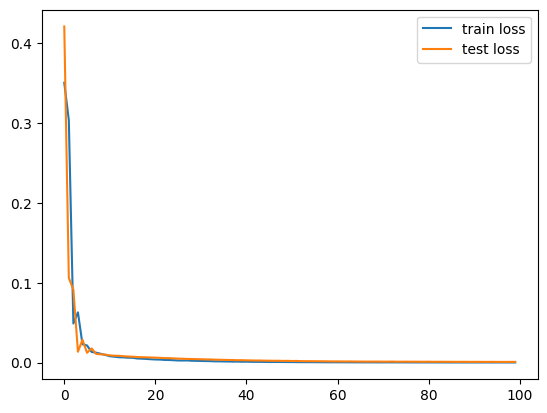

In [12]:
print(train_losses)
print(test_losses)
import matplotlib.pyplot as plt
# plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
# save the figure to figures folder
plt.savefig('figures/loss.png')
plt.show()


In [13]:
from sklearn.metrics import accuracy_score

# Assuming model, X_train, X_test, y_train, y_test are already defined
# and 'device' is your CUDA device (like torch.device("cuda:0"))

with torch.no_grad():
    # Move X_train and X_test to the device
    X_train = X_train.to(device)
    X_test = X_test.to(device)

    # Get predictions
    p_train = model(X_train)
    p_test = model(X_test)

    # Move predictions back to CPU and convert to NumPy arrays
    p_train = p_train.cpu().numpy()
    p_test = p_test.cpu().numpy()
    
    # save the predictions and actual values to csv
    np.savetxt('data/nn_predictions.csv', p_test, delimiter=',')
    np.savetxt('data/nn_actual.csv', y_test, delimiter=',')

# Print predictions and actual values
print('Predict is', p_test)
print('The real is', y_test)

Predict is [[0.66110927]
 [0.6095534 ]
 [0.6323918 ]
 [0.6311982 ]
 [0.61921996]
 [0.6678865 ]
 [0.6536354 ]
 [0.6443409 ]
 [0.6365202 ]
 [0.64670616]
 [0.61263484]
 [0.6729644 ]
 [0.6490744 ]
 [0.6501023 ]
 [0.69060194]
 [0.6208137 ]
 [0.64237636]
 [0.6393255 ]
 [0.61265516]
 [0.66323274]
 [0.67384213]
 [0.72202   ]
 [0.62865305]
 [0.70280653]
 [0.6439615 ]
 [0.61837393]
 [0.6658557 ]
 [0.6767178 ]
 [0.6553195 ]
 [0.64359504]
 [0.6886855 ]
 [0.63021266]
 [0.6114883 ]
 [0.6316208 ]
 [0.6579878 ]
 [0.6331765 ]
 [0.63241917]
 [0.6167295 ]
 [0.648584  ]
 [0.6457292 ]
 [0.6396849 ]
 [0.6759439 ]
 [0.6102149 ]
 [0.6619213 ]
 [0.6535463 ]
 [0.6131744 ]
 [0.65202606]
 [0.66406703]
 [0.6631689 ]
 [0.62463254]
 [0.6695798 ]
 [0.6680214 ]
 [0.6374669 ]
 [0.6522493 ]
 [0.5894465 ]
 [0.63203037]
 [0.65834373]
 [0.630716  ]
 [0.64972883]
 [0.66313696]
 [0.67042905]
 [0.6293132 ]
 [0.6171451 ]
 [0.66102153]
 [0.6797123 ]
 [0.65256256]
 [0.6683187 ]
 [0.67833793]
 [0.6791722 ]
 [0.65837294]
 [0.67953

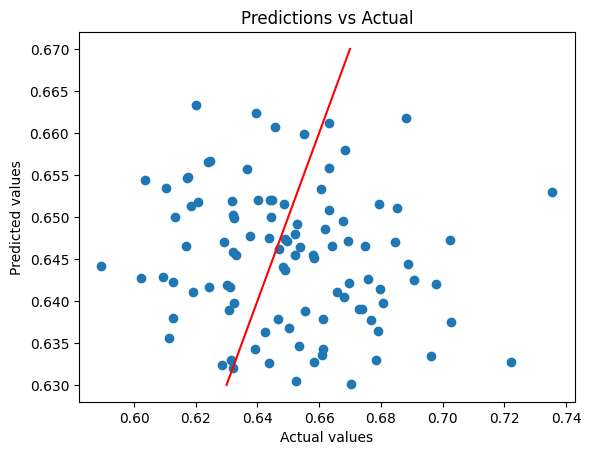

In [14]:
# draw the p_test and y_test by scatter plot
import matplotlib.pyplot as plt
plt.scatter(p_test, y_test)
plt.plot([0.63, 0.67], [0.63, 0.67], 'r')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predictions vs Actual')
# save the figure to figures folder
plt.savefig('figures/nn_prediction vs Acutural.png')

In [15]:
# save the train and test loss to csv
np.savetxt('data/nn_train_losses.csv', train_losses, delimiter=',')
np.savetxt('data/nn_test_losses.csv', test_losses, delimiter=',')

In [16]:
# save the model to checkpoint folder
torch.save(model.state_dict(), 'checkpoint/model1.pth')